<a href="https://colab.research.google.com/github/shiva7579/Machine_learning/blob/main/Functional_Subclassing_malaria_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,InputLayer,BatchNormalization,Input
from tensorflow.keras import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from google.colab import drive

In [ ]:
dataset,dataset_info=tfds.load("malaria",with_info=True,as_supervised=True,shuffle_files=True,split=['train'])
dataset

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete8BZ4UL/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [ ]:
def splits(dataset,train_ratio,val_ratio,test_ratio):
  dataset_size=len(dataset)

  train_dataset= dataset.take(int(train_ratio*dataset_size))

  val_test_dataset=dataset.skip(int(train_ratio*dataset_size))
  val_dataset=val_test_dataset.take(int(val_ratio*dataset_size))

  test_dataset=val_test_dataset.skip(int(val_ratio*dataset_size))

  return train_dataset,val_dataset,test_dataset


In [ ]:
train_ratio=0.8
val_ratio=0.1
test_ratio=0.1

#dataset=tf.data.Dataset.range(10)
#list(dataset.as_numpy_iterator())

train_dataset,val_dataset,test_dataset=splits(dataset[0],train_ratio,val_ratio,test_ratio)
#print(list(train_dataset.take(1).as_numpy_iterator()))

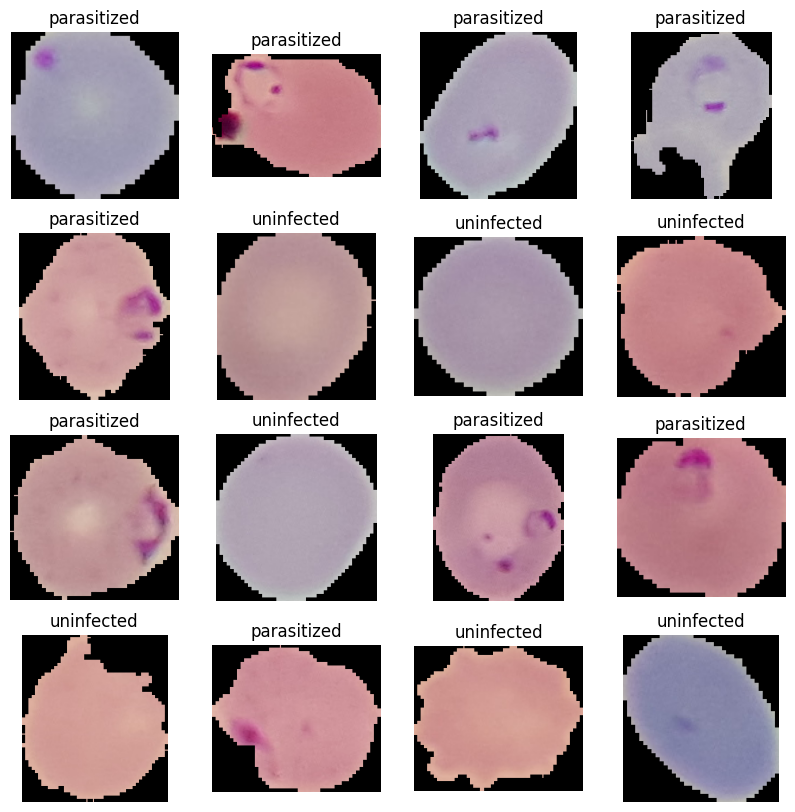

In [ ]:
plt.figure(figsize=(10,10))
for i,(image,label) in enumerate(train_dataset.take(16)):
  plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')


In [ ]:
I_m_size=224
def resize_rescale(image,label):
  return tf.image.resize(image,(I_m_size,I_m_size))/255.0,label

In [ ]:
train_dataset=train_dataset.map(resize_rescale)
val_dataset=val_dataset.map(resize_rescale)
test_dataset=test_dataset.map(resize_rescale)
print(train_dataset)
print(val_dataset)
print(test_dataset)

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [ ]:
BATCH_SIZE=32
train_dataset=train_dataset.shuffle(8,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset=val_dataset.shuffle(8,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(1)


In [ ]:
func_input=Input(shape=(I_m_size,I_m_size,3),name="Input Image")

x=tf.keras.layers.Conv2D(filters=6,kernel_size=(5,5),strides=1,padding='valid',activation='relu')(func_input)
x=BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(x)

x=tf.keras.layers.Conv2D(filters=16,kernel_size=(5,5),strides=1,padding='valid',activation='relu')(x)
x=BatchNormalization()(x)
x=tf.keras.layers.MaxPool2D(pool_size=2,strides=2)(x)

x=Flatten()(x)
x=Dense(units=120,activation='relu')(x)
x=BatchNormalization()(x)

x=Dense(units=84,activation='relu')(x)
x=BatchNormalization()(x)

func_output=Dense(units=1,activation='sigmoid')(x)

lenet_model_func=Model(func_input,func_output,name="Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 220, 220, 6)       456       
                                                                 
 batch_normalization (BatchN  (None, 220, 220, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 batch_normalization_1 (Batc  (None, 106, 106, 16)     

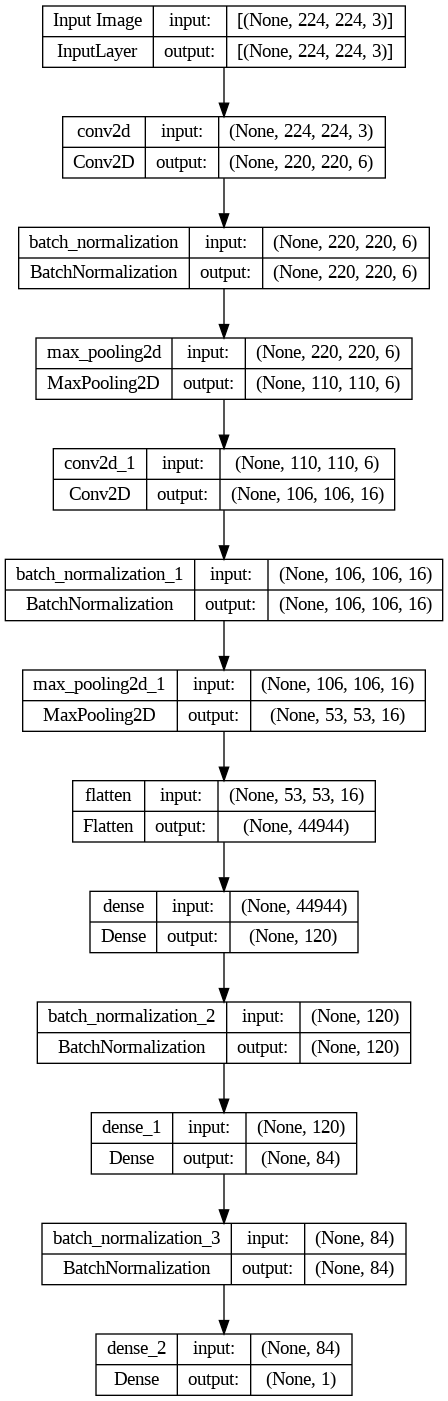

In [ ]:
tf.keras.utils.plot_model(lenet_model_func,to_file="model.png",show_shapes=True)

In [ ]:
lenet_model_func.compile (optimizer= Adam(learning_rate=0.01),
               loss= BinaryCrossentropy(),
               metrics=['Accuracy'])

In [ ]:
history=lenet_model_func.fit(train_dataset,epochs=30,validation_data=val_dataset,callbacks=EarlyStopping(patience=5,monitor='val_Accuracy'),verbose=2)

Epoch 1/30
689/689 - 62s - loss: 0.6202 - Accuracy: 0.6657 - val_loss: 1.2638 - val_Accuracy: 0.5619 - 62s/epoch - 90ms/step
Epoch 2/30
689/689 - 45s - loss: 0.3499 - Accuracy: 0.8558 - val_loss: 0.2184 - val_Accuracy: 0.9263 - 45s/epoch - 66ms/step
Epoch 3/30
689/689 - 46s - loss: 0.2067 - Accuracy: 0.9284 - val_loss: 0.1675 - val_Accuracy: 0.9416 - 46s/epoch - 67ms/step
Epoch 4/30
689/689 - 45s - loss: 0.1749 - Accuracy: 0.9409 - val_loss: 0.1924 - val_Accuracy: 0.9426 - 45s/epoch - 66ms/step
Epoch 5/30
689/689 - 54s - loss: 0.1716 - Accuracy: 0.9410 - val_loss: 0.2482 - val_Accuracy: 0.9209 - 54s/epoch - 78ms/step
Epoch 6/30
689/689 - 64s - loss: 0.1512 - Accuracy: 0.9491 - val_loss: 0.1653 - val_Accuracy: 0.9492 - 64s/epoch - 93ms/step


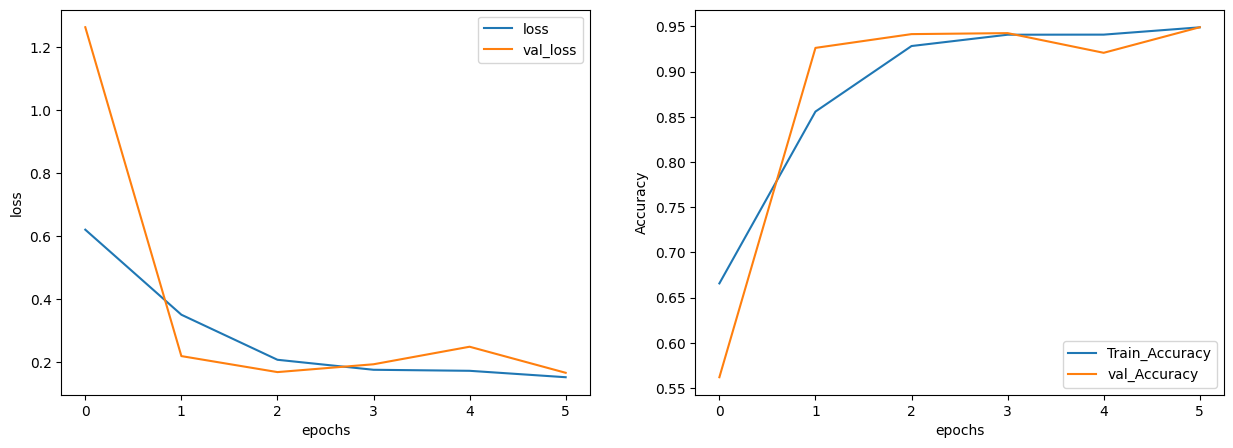

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['loss','val_loss'])

plt.subplot(1,2,2)
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['Train_Accuracy','val_Accuracy'])

In [ ]:
lenet_model_func.evaluate(test_dataset)

2757/2757 [==============================] - 28s 5ms/step - loss: 0.1982 - Accuracy: 0.9416


[0.19823096692562103, 0.9416031837463379]

**Feature_extractor**

In [ ]:
feature_exa_seq_model=Sequential([
                  InputLayer(input_shape=(I_m_size,I_m_size,3)),

                  tf.keras.layers.Conv2D(filters=6,kernel_size=(5,5),strides=1,padding='valid',activation='relu'),
                  BatchNormalization(),
                  tf.keras.layers.MaxPool2D(pool_size=2,strides=2),

                  tf.keras.layers.Conv2D(filters=16,kernel_size=(5,5),strides=1,padding='valid',activation='relu'),
                  BatchNormalization(),
                  tf.keras.layers.MaxPool2D(pool_size=2,strides=2)
])
feature_exa_seq_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 220, 220, 6)       456       
                                                                 
 batch_normalization_4 (Batc  (None, 220, 220, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 110, 110, 6)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 batch_normalization_5 (Batc  (None, 106, 106, 16)     64        
 hNormalization)                                                 
                                                        

In [ ]:
func_input=Input(shape=(I_m_size,I_m_size,3),name="Input Image")
x=feature_exa_seq_model(func_input)
x=Flatten()(x)
x=Dense(units=120,activation='relu')(x)
x=BatchNormalization()(x)

x=Dense(units=84,activation='relu')(x)
x=BatchNormalization()(x)

func_output=Dense(units=1,activation='sigmoid')(x)

lenet_model_functional_model=Model(func_input,func_output,name="Lenet_Model")
lenet_model_functional_model.summary()



Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 53, 53, 16)        2960      
                                                                 
 flatten_1 (Flatten)         (None, 44944)             0         
                                                                 
 dense_3 (Dense)             (None, 120)               5393400   
                                                                 
 batch_normalization_6 (Batc  (None, 120)              480       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 84)                10164     
                                                       

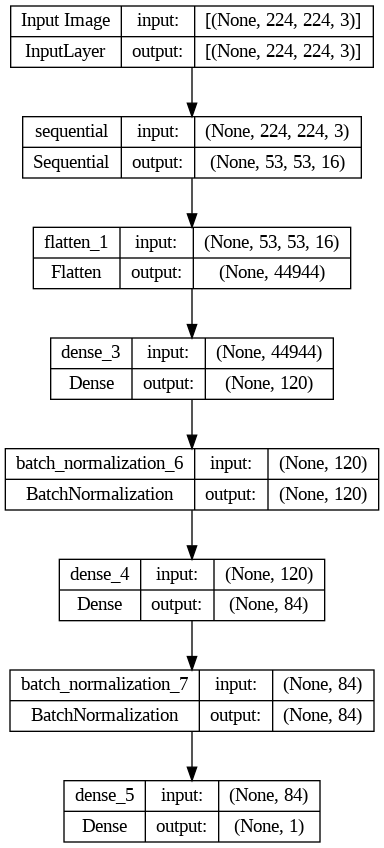

In [ ]:
tf.keras.utils.plot_model(lenet_model_functional_model,to_file="model.png",show_shapes=True)

**Model Subclassing**

In [ ]:
class featureextractor(Layer):
  def __init__(self):
    super(featureextractor,self).__init__()

    self.conv_1=tf.keras.layers.Conv2D(filters=6,kernel_size=(5,5),strides=1,padding='valid',activation='relu')
    self.batch_1=BatchNormalization()
    self.max_pool_1=tf.keras.layers.MaxPool2D(pool_size=2,strides=2)

    self.conv_2=tf.keras.layers.Conv2D(filters=16,kernel_size=(5,5),strides=1,padding='valid',activation='relu')
    self.batch_2=BatchNormalization()
    self.max_pool_2=tf.keras.layers.MaxPool2D(pool_size=2,strides=2)

  def call(self,x,training):
    
    x=self.conv_1(x)
    x=self.batch_1(x)
    x=self.max_pool_1(x)
    
    x=self.conv_2(x)
    x=self.batch_2(x)
    x=self.max_pool_2(x)

    return(x)

feature_subclassed=featureextractor()

In [ ]:
func_input=Input(shape=(I_m_size,I_m_size,3),name="Input Image")
x=feature_subclassed(func_input)
x=Flatten()(x)
x=Dense(units=120,activation='relu')(x)
x=BatchNormalization()(x)

x=Dense(units=84,activation='relu')(x)
x=BatchNormalization()(x)

func_output=Dense(units=1,activation='sigmoid')(x)

lenet_model_functional_model=Model(func_input,func_output,name="Lenet_Model")
lenet_model_functional_model.summary()


Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 featureextractor (featureex  (None, 53, 53, 16)       2960      
 tractor)                                                        
                                                                 
 flatten_2 (Flatten)         (None, 44944)             0         
                                                                 
 dense_6 (Dense)             (None, 120)               5393400   
                                                                 
 batch_normalization_10 (Bat  (None, 120)              480       
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 84)                

**Subclass_Model**

In [ ]:
class Lenet(Model):
  def __init__(self):
    super(Lenet,self).__init__()

    self.Feature_extractor=featureextractor()

    self.flatten=Flatten()

    self.dense_1=Dense(units=120,activation='relu')
    self.norm_1=BatchNormalization()

    self.dense_2=Dense(units=84,activation='relu')
    self.norm_2=BatchNormalization()

    self.dense_3=Dense(units=1,activation='sigmoid')
  
  def call(self,x,training):
    
    x=self.Feature_extractor(x)
    x=self.flatten(x)

    x=self.dense_1(x)
    x=self.norm_1(x)

    x=self.dense_2(x)
    x=self.norm_2(x)
    
    x=self.dense_3(x)

    return(x)

lenet_subclassed=Lenet()
lenet_subclassed(tf.zeros([1,224,224,3]))
lenet_subclassed.summary()


Model: "lenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 featureextractor_1 (feature  multiple                 2960      
 extractor)                                                      
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_9 (Dense)             multiple                  5393400   
                                                                 
 batch_normalization_14 (Bat  multiple                 480       
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            multiple                  10164     
                                                                 
 batch_normalization_15 (Bat  multiple                 336   

In [ ]:
lenet_subclassed.compile(optimizer= Adam(learning_rate=0.01),
               loss= BinaryCrossentropy(),
               metrics=['Accuracy'])

In [ ]:
history=lenet_subclassed.fit(train_dataset,epochs=30,validation_data=val_dataset,callbacks=EarlyStopping(patience=5,monitor='val_Accuracy'),verbose=2)

Epoch 1/30
689/689 - 48s - loss: 0.3773 - Accuracy: 0.8320 - val_loss: 0.1976 - val_Accuracy: 0.9358 - 48s/epoch - 70ms/step
Epoch 2/30
689/689 - 45s - loss: 0.2027 - Accuracy: 0.9340 - val_loss: 0.2786 - val_Accuracy: 0.9249 - 45s/epoch - 65ms/step
Epoch 3/30
689/689 - 46s - loss: 0.1800 - Accuracy: 0.9400 - val_loss: 0.1657 - val_Accuracy: 0.9499 - 46s/epoch - 67ms/step
Epoch 4/30
689/689 - 44s - loss: 0.1611 - Accuracy: 0.9474 - val_loss: 0.6000 - val_Accuracy: 0.9020 - 44s/epoch - 64ms/step
Epoch 5/30
689/689 - 45s - loss: 0.1472 - Accuracy: 0.9507 - val_loss: 0.3264 - val_Accuracy: 0.9303 - 45s/epoch - 66ms/step
Epoch 6/30
689/689 - 46s - loss: 0.1272 - Accuracy: 0.9577 - val_loss: 0.1549 - val_Accuracy: 0.9517 - 46s/epoch - 67ms/step
Epoch 7/30
689/689 - 44s - loss: 0.1131 - Accuracy: 0.9619 - val_loss: 0.1814 - val_Accuracy: 0.9495 - 44s/epoch - 64ms/step
Epoch 8/30
689/689 - 45s - loss: 0.0962 - Accuracy: 0.9670 - val_loss: 0.1773 - val_Accuracy: 0.9488 - 45s/epoch - 66ms/step


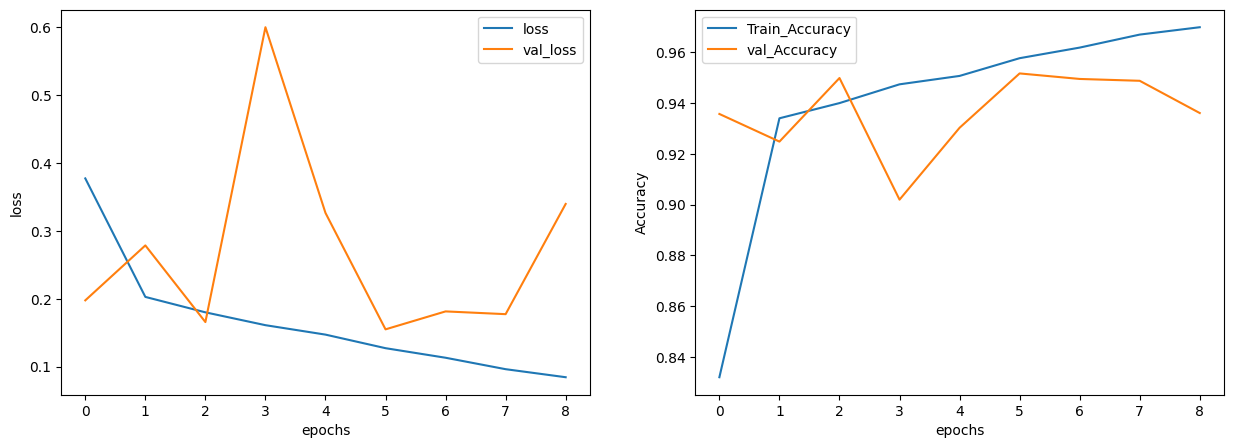

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['loss','val_loss'])

plt.subplot(1,2,2)
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['Train_Accuracy','val_Accuracy'])